In [ ]:
import pandas as pd
import jieba
from collections import Counter
import matplotlib.pyplot as plt
import re

In [ ]:
# 创建分词和停用词函数
def stopwordslist():
    with open('D:/下载/63e0e-main/63e0e-main/hit_stopwords/hit_stopwords.txt', encoding='UTF-8') as f:  #这里使用的哈工大停用词库
        stopwords = [line.strip() for line in f.readlines()]
    return stopwords

def seg_depart(sentence):
    # 创建一个停用词列表
    stopwords = stopwordslist()
    
    # 对文档中的每一行进行中文分词
    sentence_depart = jieba.cut(sentence.strip(), cut_all=False)
    
    # 输出结果为 outstr
    outstr = ''
    
    # 去停用词
    for word in sentence_depart:
        if word not in stopwords and word != '\t':
            outstr += word + " "
    
    return outstr.strip()  # 去掉最后的空格


In [3]:
#尝试判断每个帖子主题类型，使用TF-IDF方法计算关键词权重

import pandas as pd
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer

#获取每个帖子的分词后、去停用词后内容，一个帖子作为一个文档
# 读取数据
df = pd.read_csv("C:/Users/茜.NAY-LAPTOP/Desktop/Douban_data_cleaned_file.csv")
# 将正文列和回复列的文字内容进行合并，生成新列'combined'
df['combined'] = df['post_content'].fillna('') + ' ' + df['replies'].fillna('')
# 对该列内容使用上一格的分词停用词函数，将处理过的数据储存在新列'processed'
df['processed'] = df['combined'].apply(seg_depart)


# 设定每个贴子里需要遍历的所有关键词，用TF-IDF去计算每个关键词在贴子里的权重（如未提到就是0）
custom_vocabulary = [
    '情感', '投资', '假冒', '恋爱', '甜言蜜语', '信任', '聊天', '网络', '耐心', '杀猪', '社交',
    '短信', '电话', '链接', '官方', '信息', '电信诈骗', '电话诈骗',
    '刷单', '佣金', '返利', '上单', '任务', '订单',
    '登录', '账户', '钓鱼', '验证码', '网站',
    '项目', '高收益', '回报', '风险低', '低风险', '合同', '承诺',
    '淘宝', '京东', '网购', '优惠', '假', '假货', '质量', '退款', '客服', '商品'
]


#指定使用的关键词列表
vectorizer = TfidfVectorizer(vocabulary=custom_vocabulary)
# 计算 TF-IDF 矩阵，行为文档，列为关键词，数据为权重
tfidf_matrix = vectorizer.fit_transform(df['processed'])
feature_names = vectorizer.get_feature_names_out()

# 定义诈骗类型和对应的关键词
fraud_types = {
    '杀猪盘': ['情感', '投资', '假冒', '恋爱', '甜言蜜语', '信任', '聊天', '网络', '耐心', '杀猪', '社交'],
    '电信诈骗': ['短信', '电话', '链接', '官方', '信息', '电信诈骗', '电话诈骗'],
    '网络刷单': ['刷单', '佣金', '返利', '上单', '任务', '订单'],
    '钓鱼网站': ['登录', '账户', '信息', '钓鱼', '验证码', '网站'],
    '投资诈骗': ['投资', '项目', '高收益', '回报', '风险低', '低风险', '合同', '承诺'],
    '网购诈骗': ['淘宝', '京东', '网购', '订单', '优惠', '假', '假货', '质量', '退款', '客服', '商品']
}


# 定义识别每个帖子的诈骗类型的函数
def identify_fraud_type(tfidf_row):
    max_weight = 0  #权重初始值
    identified_type = '无诈骗类型'  # 默认值
    
    #每个文档里遍历这些关键词，fraud_字典中每个键相关的关键词权重进行求和，得出每个诈骗类型总权重
    for fraud_type, keywords in fraud_types.items():
        total_weight = sum(tfidf_row[vectorizer.vocabulary_[keyword]] for keyword in keywords if keyword in vectorizer.vocabulary_)
        
        #总权重最高的键会被识别为该帖子的类型
        if total_weight > max_weight:
            max_weight = total_weight
            identified_type = fraud_type

    return identified_type


df['fraud_type'] = [identify_fraud_type(tfidf_matrix[i].toarray()[0]) for i in range(tfidf_matrix.shape[0])]





#输出
fraud_counts = df['fraud_type'].value_counts()
print("每个诈骗类型的数量统计：")
print(fraud_counts)

# 解析时间并提取年份（不指定格式，让 Pandas 自动推断）
df['post_time'] = pd.to_datetime(df['post_time'])
df['year'] = df['post_time'].dt.year
# 展开 fraud_types 列并统计每个年份的每种诈骗类型的数量
# 将每个帖子可能的多种诈骗类型展开为多行
exploded_df = df.explode('fraud_type')
# 统计每年每种诈骗类型的数量
yearly_fraud_counts = exploded_df.groupby(['year', 'fraud_type']).size().unstack(fill_value=0)
print("每年出现的不同诈骗类型的数量：")
print(yearly_fraud_counts)

每个诈骗类型的数量统计：
fraud_type
杀猪盘      1676
无诈骗类型    1556
电信诈骗     1174
网购诈骗      535
钓鱼网站      360
网络刷单      234
投资诈骗      153
Name: count, dtype: int64
每年出现的不同诈骗类型的数量：
fraud_type  投资诈骗  无诈骗类型  杀猪盘  电信诈骗  网络刷单  网购诈骗  钓鱼网站
year                                                
2019           0      6    2     1     0     1     1
2020           6    219  295    50     6    29    30
2021          25    672  989   206    40    84    78
2022          70    426  265   604   123   270   170
2023          38    170  104   247    53   116    64
2024          14     63   21    66    12    35    17


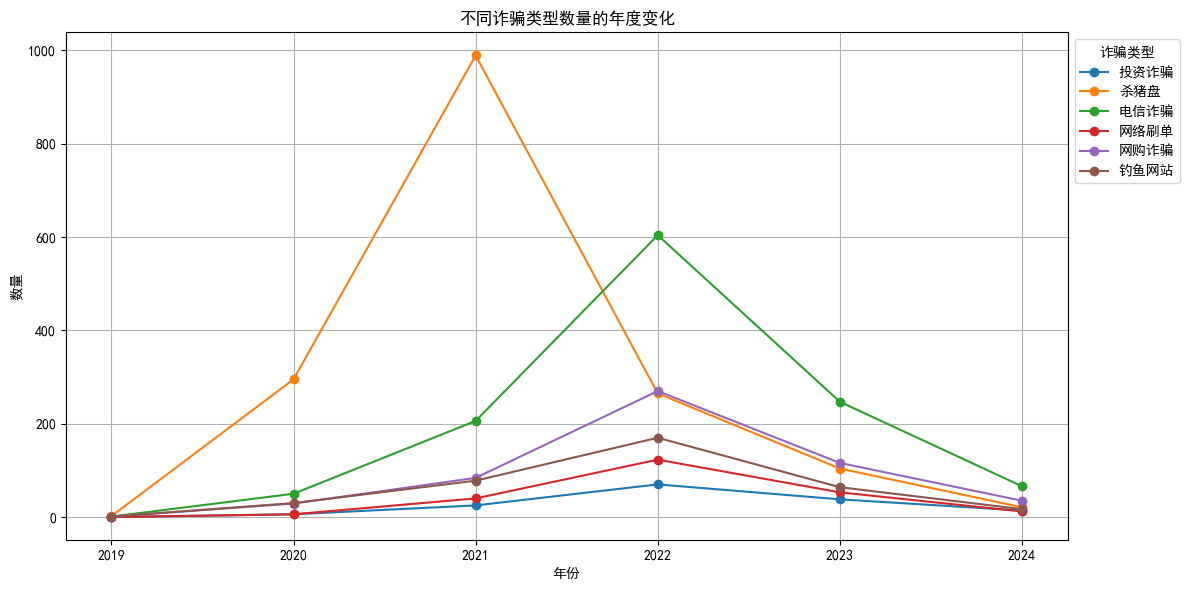

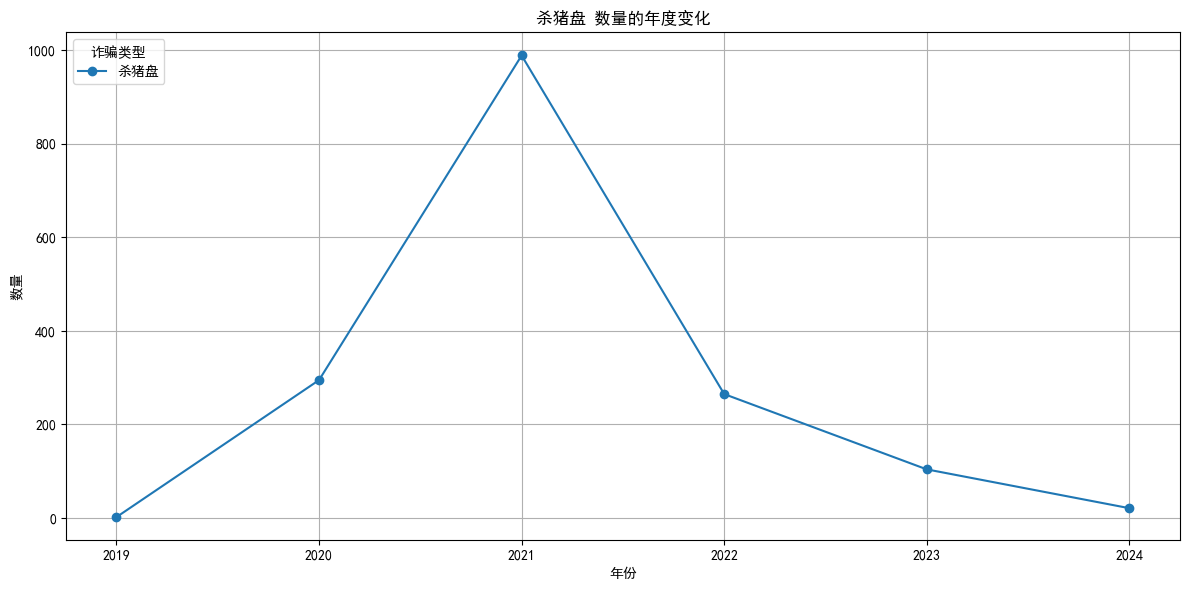

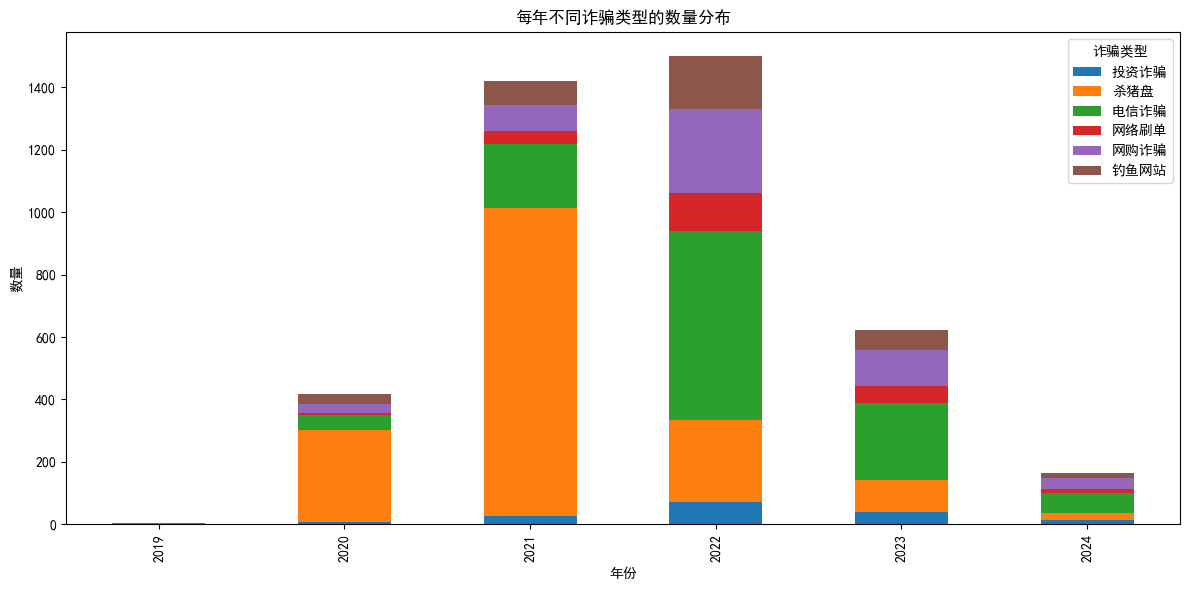

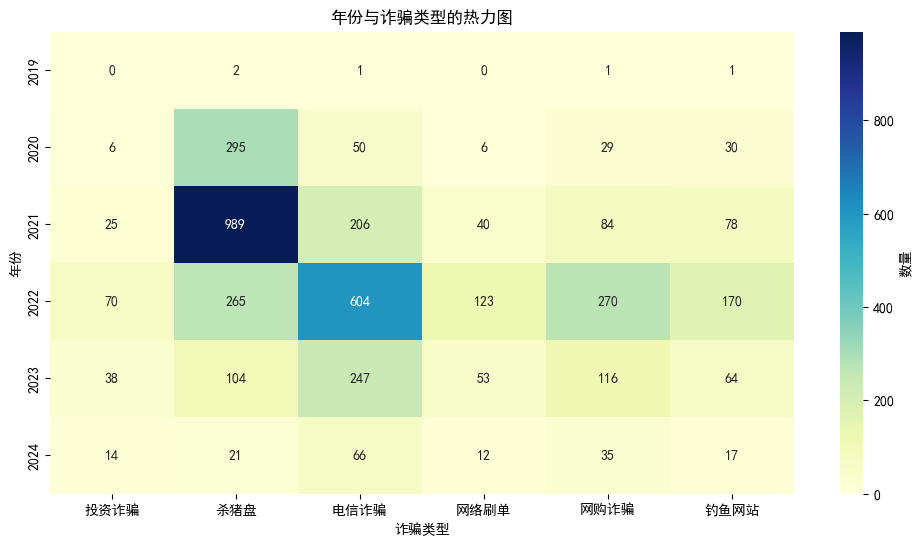

In [4]:
#可视化

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


yearly_fraud_counts = yearly_fraud_counts.fillna(0)  # 替换 NaN 为 0

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题
yearly_fraud_counts = yearly_fraud_counts.drop(columns=['无诈骗类型'], errors='ignore')



# 1. 折线图
plt.figure(figsize=(12, 6))
for fraud_type in yearly_fraud_counts.columns:
    plt.plot(yearly_fraud_counts.index, yearly_fraud_counts[fraud_type], marker='o', label=fraud_type)

plt.title('不同诈骗类型数量的年度变化')
plt.xlabel('年份')
plt.ylabel('数量')

plt.legend(title='诈骗类型', loc='upper left', bbox_to_anchor=(1, 1))  
plt.grid()
plt.xticks(yearly_fraud_counts.index)  
plt.tight_layout()
plt.show()


#1.1. 只看某个类型的
fraud_type_to_display = '杀猪盘'
plt.figure(figsize=(12, 6))
plt.plot(yearly_fraud_counts.index, yearly_fraud_counts[fraud_type_to_display], marker='o', label=fraud_type_to_display)

plt.title(f'{fraud_type_to_display} 数量的年度变化')
plt.xlabel('年份')
plt.ylabel('数量')

plt.legend(title='诈骗类型', loc='upper left')
plt.grid()
plt.xticks(yearly_fraud_counts.index)  
plt.tight_layout()
plt.show()


#2. 堆叠柱状图
yearly_fraud_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('每年不同诈骗类型的数量分布')
plt.xlabel('年份')
plt.ylabel('数量')
plt.legend(title='诈骗类型')
plt.tight_layout()
plt.show()


# 3. 热力图
plt.figure(figsize=(12, 6))
sns.heatmap(yearly_fraud_counts, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': '数量'})
plt.title('年份与诈骗类型的热力图')
plt.xlabel('诈骗类型')
plt.ylabel('年份')
plt.show()